https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

np.random.seed(0)

# 1. Read Data

In [2]:
df = pd.read_pickle('climate_change/df.pkl')
avg_temp_df = pd.read_pickle('climate_change/avg_temp_df.pkl')
std_temp_df = pd.read_pickle('climate_change/std_temp_df.pkl')
month_df = pd.read_pickle('climate_change/month_df.pkl')
sel_cities = pd.read_pickle('climate_change/sel_cities.pkl')

# 2. Generate Graphs

## 2.1. Spatial Graph

In [3]:
df['Latitude'] = df['Latitude'].str[:-1].astype(float)
df['Longitude'] = df['Longitude'].str[:-1].astype(float)
geo_df = df.groupby('City')[['Latitude', 'Longitude']].mean().loc[sel_cities]

In [4]:
alpha = 0.1
A_cities = np.exp(-alpha*pairwise_distances(geo_df))
A_cities[range(A_cities.shape[0]), range(A_cities.shape[0])] = 0
A_cities = pd.DataFrame(A_cities, index=geo_df.index, columns=geo_df.index)

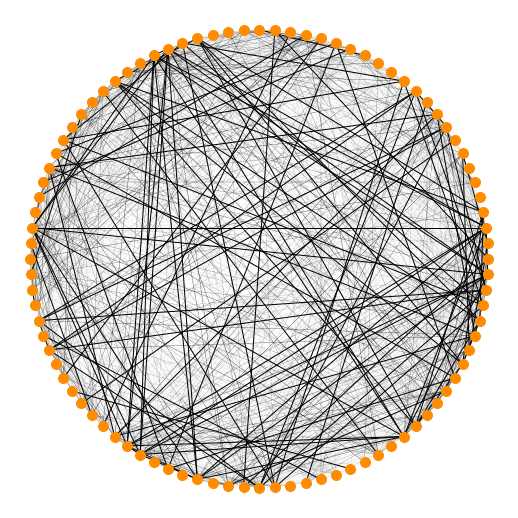

In [5]:
# PLOTTING FUNCITONS
import networkx as nx

# cols = [f'C{c}' for c in A_cities.columns]
# A_cities.columns, A_cities.index = cols, cols

G = nx.from_pandas_adjacency(A_cities, create_using=nx.Graph)
edges = G.edges()
weights = [G[u][v]['weight']**8 *1 for u,v in edges]

plt.figure(figsize=(7, 7))
nx.draw_circular(G, edges=edges, with_labels=False, 
                 node_size=100, node_color='DARKORANGE', 
                 font_color='white', font_weight=1000, font_size=20,
                 width=weights, arrowsize=30)
                 #edge_color=weights, edge_cmap=plt.get_cmap("cool"), width=3)

plt.savefig('A_s.png', dpi=300)

## 2.2. Time Graph

In [6]:
# Adjacency matrix as a constant variable (N x N)
lbw = 24
damping_constant = 0.9
A_t = np.zeros((lbw, lbw))
for row_idx in range(A_t.shape[0]):
    for col_idx in range(A_t.shape[1]):
        if col_idx > row_idx:
            A_t[row_idx, col_idx] = damping_constant**(col_idx-row_idx)

A_t = A_t.T
A_t = pd.DataFrame(A_t)

A_t.head(5)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.9000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.8100,0.900,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.7290,0.810,0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6561,0.729,0.81,0.9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


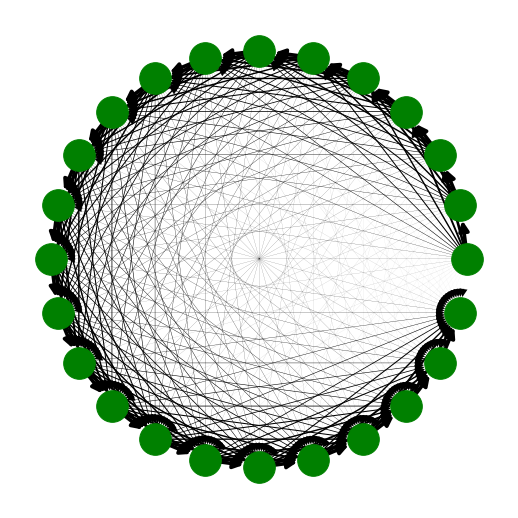

In [7]:
# PLOTTING FUNCITONS
import networkx as nx

cols = [f'T{c}' for c in A_t.columns]
A_t.columns, A_t.index = cols, cols

G = nx.from_pandas_adjacency(A_t.T, create_using=nx.DiGraph)
edges = G.edges()
weights = [G[u][v]['weight']**3 *5 for u,v in edges]

plt.figure(figsize=(7, 7))
nx.draw_circular(G, edges=edges, with_labels=False, 
                 node_size=1000, node_color='GREEN', 
                 font_color='white', font_weight=1000, font_size=20,
                 width=weights, arrowsize=20)
                 #edge_color=weights, edge_cmap=plt.get_cmap("cool"), width=3)

plt.savefig('A_t.png', dpi=300)

# 3. Generate Tensor Data

In [8]:
X, Y = [], []
for t in avg_temp_df.index[lbw:]:
    X_sample = []
    X_sample.append(avg_temp_df.loc[:t].iloc[-lbw-1:-1].values)
    X_sample.append(std_temp_df.loc[:t].iloc[-lbw-1:-1].values)
    X_sample.append(month_df.loc[:t].iloc[-lbw-1:-1].values)
    X.append(np.array(X_sample))
    Y.append(avg_temp_df.loc[t].values)
    
X, Y = np.array(X), np.array(Y)
X = X.transpose((0, 2, 3, 1))
print(X.shape, Y.shape)

(3215, 24, 92, 3) (3215, 92)


In [9]:
# Train-test split
split_idx = int(0.7*X.shape[0])
X_tr, Y_tr = X[:split_idx], Y[:split_idx]
X_te, Y_te = X[split_idx:], Y[split_idx:]

# 4. Modelling

- check the transpose of the time graph 
- use the learnable (I + \alpha * A) filter

## 4.1. MGTN 

In [10]:
import tensorflow as tf
from GraphTensorNetworks import SpecialMultiGraphTensorNetwork as SMGTN
from GraphTensorNetworks import TensorTrainLayer as TTL

tf.random.set_seed(0)

In [11]:
graph_list = [A_t.values, A_cities.values]
tt_ips = [X.shape[1], X.shape[2], 32]
tt_ops = [2,2,2]
tt_ranks = [1,2,2,1]

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X.shape[1:]))

model.add(SMGTN(tt_ips[-1], graph_list, bias_bool=False))
model.add(tf.keras.layers.Activation('tanh'))

model.add(TTL(tt_ips, tt_ops, tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
special_multi_graph_tensor_n (None, 24, 92, 32)        98        
_________________________________________________________________
activation (Activation)      (None, 24, 92, 32)        0         
_________________________________________________________________
tensor_train_layer (TensorTr (None, 2, 2, 2)           968       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 2)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 92)                828       
Total params: 1,894
Trainable params: 1,894
Non-trainable params: 0
______________________________________________________

In [13]:
model.fit(X_tr, Y_tr, validation_split=0.2, epochs=30, shuffle=False, verbose=False)

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
preds = model.predict(X_tr)
mean_squared_error(preds.reshape(-1), Y_tr.reshape(-1))

0.025701131595497976

In [16]:
preds = model.predict(X_te)
mean_squared_error(preds.reshape(-1), Y_te.reshape(-1))

0.018814213711660525

## 4.2. TTNN

In [17]:
X_tr.shape

(2250, 24, 92, 3)

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X.shape[1:]))

model.add(TTL([24, 92, 3], [4, 4, 2], tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))

model.add(TTL([4, 4, 2], tt_ops, tt_ranks))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor_train_layer_1 (Tensor (None, 4, 4, 2)           1708      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 4, 2)           0         
_________________________________________________________________
tensor_train_layer_2 (Tensor (None, 2, 2, 2)           64        
_________________________________________________________________
activation_3 (Activation)    (None, 2, 2, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 92)                828       
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
____________________________________________________

In [19]:
model.fit(X_tr, Y_tr, validation_split=0.2, epochs=30, shuffle=False, verbose=False)

In [20]:
preds = model.predict(X_tr)
mean_squared_error(preds.reshape(-1), Y_tr.reshape(-1))

0.02317877218489867

In [21]:
preds = model.predict(X_te)
mean_squared_error(preds.reshape(-1), Y_te.reshape(-1))

0.01986236403770777

## 4.3. GRU Model

In [22]:
X_tr_gru = X_tr.reshape(X_tr.shape[0], lbw, -1)
X_te_gru = X_te.reshape(X_te.shape[0], lbw, -1)

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=X_tr_gru.shape[1:]))

model.add(tf.keras.layers.GRU(32, return_sequences=True))
model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(2**3))
model.add(tf.keras.layers.Activation('tanh'))

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 32)            29760     
_________________________________________________________________
activation_4 (Activation)    (None, 24, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 6152      
_________________________________________________________________
activation_5 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 92)                828       
Total params: 36,740
Trainable params: 36,740
Non-trainable params: 0
__________________________________________________

In [24]:
model.fit(X_tr_gru, Y_tr, validation_split=0.2, epochs=30, shuffle=False, verbose=False)

In [25]:
preds = model.predict(X_tr_gru)
mean_squared_error(preds.reshape(-1), Y_tr.reshape(-1))

0.027040084236816635

In [26]:
preds = model.predict(X_te_gru)
mean_squared_error(preds.reshape(-1), Y_te.reshape(-1))

0.04376361198946705

## 4.4. GCN

In [27]:
X_tr_gcn = X_tr.transpose(0, 2, 1, 3).reshape(X_tr.shape[0], A_cities.shape[0], -1)
X_te_gcn = X_te.transpose(0, 2, 1, 3).reshape(X_te.shape[0], A_cities.shape[0], -1)

In [28]:
from GraphTensorNetworks import GraphCNN

In [29]:
g_filter = tf.keras.backend.constant(A_cities.values + np.eye(A_cities.shape[0]))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(A_cities.shape[0], X_tr_gcn.shape[-1])))

model.add(GraphCNN(output_dim=32, num_filters=1, graph_conv_filters=g_filter, input_shape=X_tr_gcn.shape[1:]))
model.add(tf.keras.layers.Activation('tanh'))

# model.add(GraphCNN(output_dim=8, num_filters=1, graph_conv_filters=g_filter, input_shape=X_tr_gcn.shape[1:]))
# model.add(tf.keras.layers.Activation('tanh'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(3**3))
model.add(tf.keras.layers.Activation('tanh'))

model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.01))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_cnn (GraphCNN)         (None, 92, 32)            2304      
_________________________________________________________________
activation_6 (Activation)    (None, 92, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2944)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                79515     
_________________________________________________________________
activation_7 (Activation)    (None, 27)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 92)                2576      
Total params: 84,395
Trainable params: 84,395
Non-trainable params: 0
__________________________________________________

In [30]:
model.fit(X_tr_gcn, Y_tr, validation_split=0.2, epochs=30, shuffle=False, verbose=False)

In [31]:
preds = model.predict(X_tr_gcn)
mean_squared_error(preds.reshape(-1), Y_tr.reshape(-1))

0.03849416376321801

In [32]:
preds = model.predict(X_te_gcn)
mean_squared_error(preds.reshape(-1), Y_te.reshape(-1))

0.027184922195442558